In [3]:
from Bio import SeqIO
import collections
import pandas as pd 
import re
import requests
import json
import time
from collections import Counter
import glob
import pprint
import seaborn as sns
import pylab as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import pycountry 
import pycountry_convert as pc
pp = pprint.PrettyPrinter()
import numpy as np
from tabulate import tabulate
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import math
from sklearn.linear_model import LinearRegression



## 1. Open data and calculate fractional

In [8]:
df = pd.read_csv('PATH\data\CoR-allauth_Genbank[OBIS_and_patents].csv')

In [9]:
df2 = df.replace({'affiliation_country_ed': {'': np.nan}}).drop(columns=['titles']).dropna(subset = ['affiliation_country_ed'])

In [10]:
len(set(df['pubmed_id']))

23417

In [11]:
len(set(df2['pubmed_id']))

23231

In [ ]:
fractional_counts_inst = []
fractional_counts_country = []
pubmed_counts_inst = {}
pubmed_counts_country = {}
for pub in list(df2['pubmed_id']): 
    if pub not in pubmed_counts_inst:
        pubmed_counts_inst[pub] = len(df2[['pubmed_id', 'affiliation']][df2['pubmed_id'] == pub].drop_duplicates())
        pubmed_counts_country[pub] = len(df2[['pubmed_id', 'affiliation_country_ed']][df2['pubmed_id'] == pub].drop_duplicates())
    fractional_counts_inst.append(1/pubmed_counts_inst[pub])
    fractional_counts_country.append(1/pubmed_counts_country[pub])

In [ ]:
df2['fractional_count_inst'] = fractional_counts_inst
df2['fractional_count_country'] = fractional_counts_country

In [ ]:
df2['times_cited_sci_fract'] = df2['times_cited_sci']*df2['fractional_count_country']
df2['times_cited_pat_fract'] = df2['times_cited_pat']*df2['fractional_count_country']

## 2. Plotting scientific landscape (Result 1) 

In [ ]:
# add econ group
# load g77 and OECD data, assign overlapping to g77
g77 = pd.read_csv('PATH\data\g77.csv')
oecd = pd.read_csv('PATH\data\oecd.csv')

delete_from_oecd = []

for i in list(g77['Code']): 
    if i in list(oecd['Code']):
        delete_from_oecd.append(i)

for i in list(g77['Code']): 
    if i in list(oecd['Code']):
        delete_from_oecd.append(i)        

oecd_clean = [x for x in list(oecd['Code']) if x not in delete_from_oecd]

econ_group = []
for i in list(df2['affiliation_country_ed']):
    if i in [pc.country_alpha3_to_country_alpha2(x) for x in oecd_clean]: 
        econ_group.append('OECD')
    elif i in ['RU','BR','IN','CN','ZA']:
        econ_group.append('BRICS')
    elif i in [pc.country_alpha3_to_country_alpha2(x) for x in g77['Code'] if x not in ['RU','BR','IN','CN','ZA']]:
        econ_group.append('G77')
    elif pd.isna(i): 
        econ_group.append(np.nan)
    else: 
        econ_group.append('other')
        
df2['econ_group'] = econ_group

In [ ]:
# Affiliations 
df_affiliations = df2[['pubmed_id','affiliation_country_ed','affiliation', 'fractional_count_inst', 'econ_group']].drop_duplicates()
df_papers = df_affiliations.groupby(['affiliation'])['fractional_count_inst'].sum().reset_index(name='Papers_fract').sort_values(['Papers_fract'], ascending=False)
df_affiliations_vis = pd.merge(df_papers, df_affiliations[['affiliation', 'affiliation_country_ed', 'econ_group']].drop_duplicates(), how = 'left', on = 'affiliation').rename(columns = {'affiliation':'Affiliation','Papers_fract':'Papers','econ_group':'Econ Group','affiliation_country_ed':'Country'})

In [ ]:
print(tabulate(df_affiliations_vis[['Affiliation', 'Papers', 'Country', 'Econ Group']][:20].rename(columns = {'affiliation' : 'Affiliation', 'econ_group':'Group'}).set_index('Affiliation'), headers='keys', tablefmt='fancy_grid',  numalign="left", stralign = "left"))


In [ ]:
#Countries
df_countries = df2[['pubmed_id','affiliation_country_ed','fractional_count_country', 'econ_group','times_cited_sci', 'times_cited_pat','times_cited_sci_fract','times_cited_pat_fract']].fillna(0).drop_duplicates()

#papers
df_papers_country = df_countries.groupby(['affiliation_country_ed'])['fractional_count_country'].sum().reset_index(name='Papers_fract').sort_values(['Papers_fract'], ascending=False)

#citations
df_sci_cit_country = df_countries.groupby(['affiliation_country_ed'])['times_cited_sci_fract'].sum().reset_index(name='Citations by sci_fract').sort_values(['Citations by sci_fract'], ascending=False)
df_pat_cit_country = df_countries.groupby(['affiliation_country_ed'])['times_cited_pat_fract'].sum().reset_index(name='Citations by pat_fract').sort_values(['Citations by pat_fract'], ascending=False)

df_papers_country['Citations by sci_fract'] = df_sci_cit_country['Citations by sci_fract']
df_papers_country['Citations by pat_fract'] = df_pat_cit_country['Citations by pat_fract']

#means
df_papers_country['Av citations by sci_fract'] = df_papers_country['Citations by sci_fract']/df_papers_country['Papers_fract']
df_papers_country['Av citations by pat_fract'] = df_papers_country['Citations by pat_fract']/df_papers_country['Papers_fract']

#econ groups
df_countries_vis = pd.merge(df_papers_country, df_countries[['affiliation_country_ed', 'econ_group']].drop_duplicates(), how = 'left', on = 'affiliation_country_ed').rename(columns = {'Papers_fract':'Papers','econ_group':'Econ Group','affiliation_country_ed':'Country'})

In [21]:
df_countries.to_csv('PATH\data\COR_fractional_scores.csv')

In [ ]:
df_countries_vis['country_paper_percentage'] = 100*df_countries_vis['Papers']/df_countries_vis['Papers'].sum()
df_countries_vis['country_sci_cit_percentage'] = 100*df_countries_vis['Citations by sci_fract']/df_countries_vis['Citations by sci_fract'].sum()

In [ ]:
df_countries_vis[:20]

In [ ]:
df_groups_vis = df_countries_vis.groupby('Econ Group')['Papers'].sum().reset_index()

In [ ]:
df_groups_vis['group_percentage'] = 100*df_groups_vis['Papers']/df_groups_vis['Papers'].sum()

In [ ]:
df_groups_vis

In [ ]:
print(tabulate(df_countries_vis[:20].drop(columns = {'Econ Group'}).set_index('Country'), headers='keys', tablefmt='fancy_grid', numalign="left", stralign = "left"))


In [ ]:
df_countries_vis[:30].set_index('Country').sort_values(['Av citations by sci_fract'], ascending = False)

In [ ]:
df_countries_vis['Papers'][:3].sum()/df_countries_vis['Papers'].sum()

In [30]:
df_countries_vis['Papers'][:3].sum()

11275.921721334234

In [31]:
df_countries_vis['Papers'][:20].sum()/df_countries_vis['Papers'].sum()

0.8882908256606119

In [32]:
df_countries_vis.set_index('Country').to_csv('PATH\data\table_COR_fract.csv')

## 3. Scatterplot of reference balances (countries)

In [4]:
df_countries_vis = pd.read_csv('PATH\data\table_COR_fract.csv')

In [5]:
df_countries_vis.corr()

,Papers,Citations by sci_fract,Citations by pat_fract,Av citations by sci_fract,Av citations by pat_fract,country_paper_percentage,country_sci_cit_percentage
Papers,1.000000,0.947784,0.905362,0.159664,0.158618,1.000000,0.947784
Citations by sci_fract,0.947784,1.000000,0.981892,0.186548,0.169953,0.947784,1.000000
Citations by pat_fract,0.905362,0.981892,1.000000,0.179005,0.216267,0.905362,0.981892
Av citations by sci_fract,0.159664,0.186548,0.179005,1.000000,0.178701,0.159664,0.186548
Av citations by pat_fract,0.158618,0.169953,0.216267,0.178701,1.000000,0.158618,0.169953
country_paper_percentage,1.000000,0.947784,0.905362,0.159664,0.158618,1.000000,0.947784
country_sci_cit_percentage,0.947784,1.000000,0.981892,0.186548,0.169953,0.947784,1.000000


<Figure size 16560x20160 with 0 Axes>

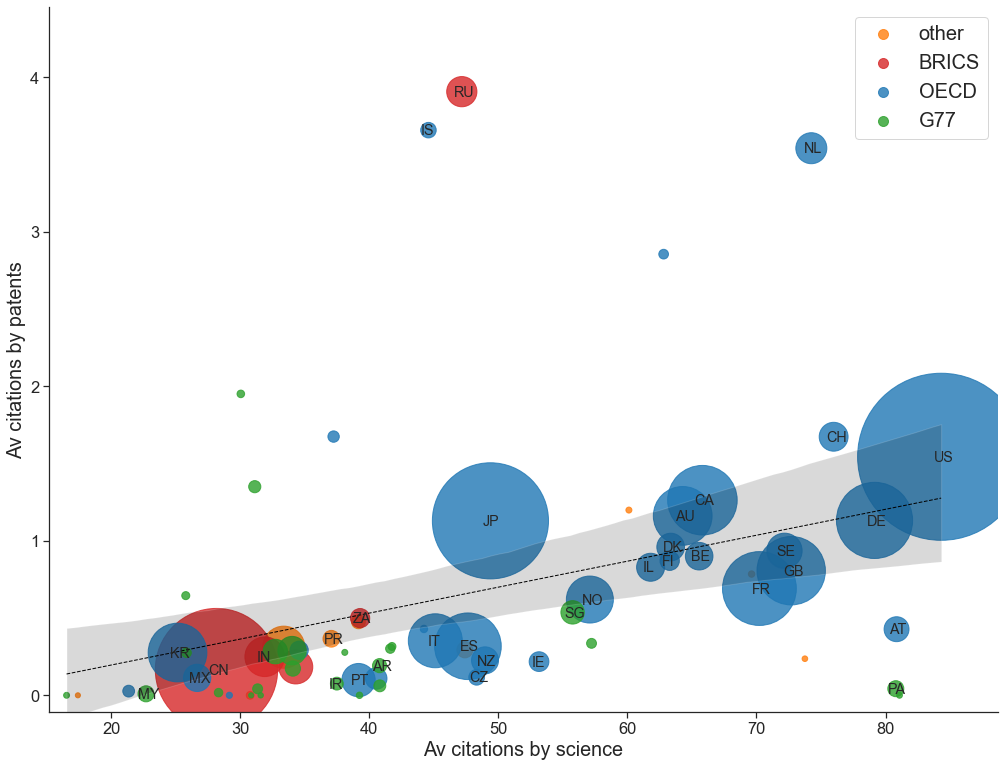

In [10]:
# Visualizing
from adjustText import adjust_text
# could add country/econ group colors
sci_av_top = df_countries_vis['Av citations by sci_fract'].quantile(0.99)
pat_av_top = df_countries_vis['Av citations by pat_fract'].quantile(0.99)

df_countries_vis_nononesense = df_countries_vis[(df_countries_vis['Av citations by sci_fract']<sci_av_top)&(df_countries_vis['Av citations by pat_fract']<pat_av_top)&(df_countries_vis['Papers']>=5)].reset_index()
plt.figure(figsize=(230,280))
sns.set_style('white')
sns.set_style('ticks')


# Using regplot to create the scatter plot with 95% confidence interval and a regression line
size = 11


g = sns.lmplot(x='Av citations by sci_fract', y='Av citations by pat_fract', data=df_countries_vis_nononesense[df_countries_vis_nononesense['Econ Group'] == 'other'], height=size, aspect=size*1.3/size, markers='o', fit_reg = False, scatter_kws={"s": df_countries_vis_nononesense['Papers'][df_countries_vis_nononesense['Econ Group'] == 'other']*5, "color":"tab:orange"}).set(xlim=(df_countries_vis_nononesense['Av citations by sci_fract'].describe()['min']-size/8,df_countries_vis_nononesense['Av citations by sci_fract'].describe()['max']+size/2.5),ylim=(df_countries_vis_nononesense['Av citations by pat_fract'].describe()['min']-size/100,df_countries_vis_nononesense['Av citations by pat_fract'].describe()['max']+size/20)) # .set_axis_labels("Provision of MGRs (CoO)","Scientific use of MGRs (CoR)")

sns.regplot(x='Av citations by sci_fract', y='Av citations by pat_fract', data=df_countries_vis_nononesense[df_countries_vis_nononesense['Econ Group'] == 'BRICS'], fit_reg = False, scatter_kws={"s": df_countries_vis_nononesense['Papers'][df_countries_vis_nononesense['Econ Group'] == 'BRICS']*5, "color":"tab:red"})#ic use of MGRs (CoR)")
sns.regplot(x='Av citations by sci_fract', y='Av citations by pat_fract', data=df_countries_vis_nononesense[df_countries_vis_nononesense['Econ Group'] == 'OECD'], fit_reg = False, scatter_kws={"s": df_countries_vis_nononesense['Papers'][df_countries_vis_nononesense['Econ Group'] == 'OECD']*5, "color":"tab:blue"})#ic use of MGRs (CoR)")
sns.regplot(x='Av citations by sci_fract', y='Av citations by pat_fract', data=df_countries_vis_nononesense[df_countries_vis_nononesense['Econ Group'] == 'G77'], fit_reg = False, scatter_kws={"s": df_countries_vis_nononesense['Papers'][df_countries_vis_nononesense['Econ Group'] == 'G77']*5, "color":"tab:green"})#ic use of MGRs (CoR)")
lgnd = plt.legend( scatterpoints=1, loc='best', labels=['other', 'BRICS','OECD', 'G77'], fontsize = 20, markerscale = 0.4)
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
lgnd.legendHandles[3]._sizes = [100]


sns.regplot(x='Av citations by sci_fract', y='Av citations by pat_fract', data=df_countries_vis_nononesense, scatter=False, ci=95, ax=g.axes[0, 0], line_kws={"color":"black","alpha":1,"lw":1,'linestyle':'--'})

N = 35  # Choose the number of top countries to label
exceptions = ['TH', 'TW', 'PL', 'CL', 'HK', 'BR', 'SA', 'GR', 'HR']
top_countries = df_countries_vis_nononesense[~df_countries_vis_nononesense['Country'].isin(exceptions)].nlargest(N, ['Papers'])

#labels = []
for i, countries in enumerate(list(top_countries['Country'])):
    plt.annotate(countries, (top_countries['Av citations by sci_fract'].iloc[i] - 0.6, top_countries['Av citations by pat_fract'].iloc[i] - 0.03), size=size * 1.3)

    #label = plt.annotate(countries, (top_countries['Av citations by sci_fract'].iloc[i] - 0.8, top_countries['Av citations by pat_fract'].iloc[i] - 0.01), size=size * 1.3)
    #labels.append(label)

    
# Use adjust_text to automatically adjust the label positions to avoid overlaps
#adjust_text(labels, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xlabel('Av citations by science', fontsize =size*1.8)
plt.ylabel('Av citations by patents', fontsize =size*1.8)
sns.set(font_scale = 1.5)
#plt.xscale('log')
#plt.yscale('log')


plt.tight_layout()
plt.savefig('PATH\plots\Science_patent_citations_country_fract.svg', format="svg")
plt.savefig('PATH\plots\Science_patent_citations_country_fract.jpg', format="jpg")

In [56]:
df_countries_vis_nononesense

,index,Country,Papers,Citations by sci_fract,Citations by pat_fract,Av citations by sci_fract,Av citations by pat_fract,Econ Group,country_paper_percentage,country_sci_cit_percentage
0,0,US,5583.366251,470722.453845,8619.637312,84.308002,1.543807,OECD,24.034119,34.655162
1,1,CN,2994.991179,84321.765172,498.246836,28.154262,0.166360,BRICS,12.892218,6.207871
2,2,JP,2697.564292,133214.787320,3046.216799,49.383360,1.129247,OECD,11.611916,9.807435
3,3,DE,1160.028913,91812.530937,1313.096836,79.146761,1.131952,OECD,4.993452,6.759351
4,4,FR,1090.423791,76576.312575,753.571836,70.226194,0.691082,OECD,4.693831,5.637642
...,...,...,...,...,...,...,...,...,...,...
65,66,AE,6.878968,557.753968,0.000000,81.081050,0.000000,G77,0.029611,0.041063
66,67,UA,6.333333,467.083333,1.500000,73.750000,0.236842,other,0.027262,0.034387
67,68,VE,5.959524,188.202381,0.000000,31.580104,0.000000,G77,0.025653,0.013856
68,69,MT,5.183333,90.266667,0.000000,17.414791,0.000000,other,0.022312,0.006646


In [57]:
df_countries_vis_nononesense.to_csv('PATH\data\df_countries_vis_nononesense_fract.csv')

In [58]:
df_countries_vis.to_csv('PATH\data\df_countries_vis_fract.csv')

In [59]:
# residuals

In [60]:
x = np.array(list(df_countries_vis_nononesense['Av citations by sci_fract'])).reshape((-1, 1))
y = np.array(list(df_countries_vis_nononesense['Av citations by pat_fract']))
model = LinearRegression().fit(x, y)

In [61]:
print(f"intercept: {model.intercept_}")
intercept: 5.633333333333329

intercept: -0.13993461532889118


In [62]:
print(f"slope: {model.coef_}")

slope: [0.01679879]


In [63]:
list(model.predict(x))

[1.2763380441894987,
 0.3330229919773454,
 0.6896462095487255,
 1.1896354205819961,
 1.039780665639333,
 0.9655860328252874,
 1.0811476042036978,
 0.6603536881368997,
 0.9399255938886337,
 0.28232192161313663,
 0.6178756097620631,
 0.8190816729976957,
 0.4205879606874505,
 0.3958372190771243,
 1.0724305847295479,
 0.43623397546473075,
 0.5179600450746076,
 1.1073545964180291,
 0.6523693892968082,
 1.136402318391881,
 0.4314309531332142,
 0.898126813658126,
 0.9242485031855903,
 0.9613540138458345,
 0.3078273985617534,
 0.6825916234226761,
 1.2183075938455354,
 0.40956677644079476,
 0.7966088726492192,
 0.5409321171845154,
 0.7529014357083523,
 0.9229789543833582,
 0.5199879473806625,
 0.4406053040943779,
 0.4825624464790439,
 0.2413230350905835,
 0.65640080103488,
 1.2173314848910035,
 0.6717125333086582,
 0.608944730904479,
 0.43246942338348693,
 0.54533247111828,
 0.5178337031894685,
 0.48969429431643574,
 0.3828341594129744,
 0.5456476038047001,
 0.21872070061849513,
 0.485486849532

In [64]:
residuals = [a - b for a, b in zip(list(y),list(model.predict(x)))]

In [65]:
df_countries_vis_nononesense['residuals'] = residuals 

In [68]:
df_countries_vis_nononesense.sort_values(['residuals'], ascending = False)[:10]

,index,Country,Papers,Citations by sci_fract,Citations by pat_fract,Av citations by sci_fract,Av citations by pat_fract,Econ Group,country_paper_percentage,country_sci_cit_percentage,residuals
18,18,RU,182.662338,8615.148918,713.650000,47.164342,3.906936,BRICS,0.786287,0.634258,3.254566
39,39,IS,48.276190,2152.121429,176.583333,44.579355,3.657773,OECD,0.207809,0.158442,3.048828
17,17,NL,192.476929,14291.169610,681.548026,74.248741,3.540934,OECD,0.828535,1.052133,2.433579
50,50,SI,18.854762,1184.166667,53.833333,62.804647,2.855158,OECD,0.081162,0.087180,1.940051
57,57,PE,11.533333,346.466667,22.500000,30.040462,1.950867,G77,0.049646,0.025507,1.586158
47,47,HU,26.013228,968.476190,43.560847,37.230143,1.674565,OECD,0.111976,0.071300,1.189078
44,44,PH,29.624242,921.889394,40.000000,31.119425,1.350245,G77,0.127520,0.067871,0.967411
19,19,CH,166.849537,12676.876786,279.203704,75.977896,1.673386,OECD,0.718219,0.933287,0.536984
2,2,JP,2697.564292,133214.787320,3046.216799,49.383360,1.129247,OECD,11.611916,9.807435,0.439601
54,54,CU,12.916667,332.916667,8.333333,25.774194,0.645161,G77,0.055601,0.024510,0.352121


In [52]:
df_countries_vis_nononesense.to_csv('PATH\data\COR_vis_fract[70].csv')